### on gradient (run every time)

In [ ]:
%%capture
pip install fastai

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  # integer pyplot ticks
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as tfms
from torchvision import models

from fastai.basics import *
from fastai.vision.all import *

import warnings
warnings.filterwarnings('ignore')

### Paths and variables

In [ ]:
# DATASET_PATH = '../datasets/'
DATASET_PATH = './dataset/'

In [ ]:
CONFIG_PATH = DATASET_PATH+'config/'
SIG_PATH = DATASET_PATH+'dataset_img/'
# SIG_PATH = DATASET_PATH+'signal/'
BG_PATH = DATASET_PATH+'background_img/'

In [ ]:
# LOG_PATH = 'gdrive/MyDrive/GW QML project/notebooks tiago/logs'
LOG_PATH = './simple_model_logs/'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### DataBlock Approach

In [ ]:
def RandomThreeSplitter(valid_pct=0.15, test_pct=0.15, seed=None):
    "Create function that splits `items` between train/val/test with `valid_pct` and `test_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(list(torch.randperm(len(o)).numpy()))
        cut_val = int(valid_pct * len(o))
        cut_test = cut_val + int(valid_pct * len(o))
        return rand_idx[cut_test:],rand_idx[:cut_val], rand_idx[cut_val:cut_test]
    return _inner

In [ ]:
transforms = [Resize(112), ToTensor]
bh_gw = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  splitter = RandomThreeSplitter(valid_pct=0.15, test_pct=0.15, seed=42),
                  get_y = parent_label,
                  item_tfms=transforms)

In [ ]:
bh_gw.summary(DATASET_PATH)

Setting-up type transforms pipelines
Found 20000 items
3 datasets of sizes 14000,3000,3000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      dataset/dataset_img/9114_sample.png
    applying PILBase.create gives
      PILImage mode=RGB size=224x224
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      dataset/dataset_img/9114_sample.png
    applying parent_label gives
      dataset_img
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=224x224, TensorCategory(1))


Found 20000 items
3 datasets of sizes 14000,3000,3000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Res

In [ ]:
dsets = bh_gw.datasets(DATASET_PATH)

In [ ]:
dsets.train[0]

(PILImage mode=RGB size=224x224, TensorCategory(1))

In [ ]:
len(dsets.train), len(dsets.valid), len(dsets.subset(2))

(14000, 3000, 3000)

In [ ]:
transforms = [Resize(112), ToTensor]
dls = DataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, device=device, after_item=transforms)

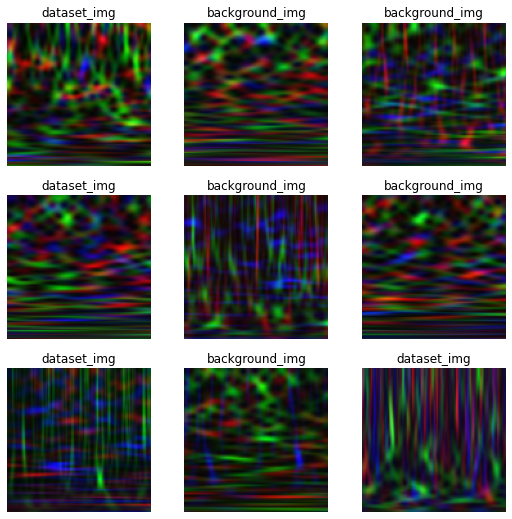

In [ ]:
dls.show_batch()

### Dataset creation

In [ ]:
class Data_GW(Dataset):
    def __init__(self, config_path, sig_path, bg_path, transform=None):
        self.config_path = Path(config_path)
        self.configs = list(self.config_path.glob('*_config.json'))
        
        labels = ('sig', 'bg')
        self.path = {'sig': Path(sig_path), 'bg': Path(bg_path)}
        self.fnames = {'sig': 'sample', 'bg': 'bg'}
        self.class_dict = {key: F.one_hot(torch.tensor(i),num_classes=2).float() 
                               for i,key in enumerate(labels)}
        self.transform = transform
        
    def __len__(self):
        return 2 * len(self.configs)

    def __getitem__(self, idx):
        label = 'sig' if (idx + 1) <= len(self.configs) else 'bg'
        sample_idx = idx + 1 if idx < 10000 else idx + 1 - len(self.configs)
        with open(self.configs[idx % len(self.configs)], 'r') as f:
            config_dict = json.load(f)
        qgraph = Image.open(self.path[label]/f'{sample_idx}_{self.fnames[label]}.png')
        
        img = qgraph
            
        if self.transform:
            img = self.transform(img)
        
        return (img, self.class_dict[label])

In [ ]:
transform = tfms.Compose([tfms.ToTensor(), tfms.Resize((112, 112))])
ds_init = Data_GW(CONFIG_PATH, SIG_PATH, BG_PATH, transform=transform)

In [ ]:
lengths = (np.array((0.7, 0.15, 0.15)) * len(ds_init)).astype(int)
ds, ds_val, ds_test = torch.utils.data.random_split(ds_init, lengths, generator=torch.Generator().manual_seed(42))

## Model: Resnet34, trained from scratch with fit_one_cycle

#### batch size 64

In [ ]:
dls = DataLoaders.from_dsets(ds, ds_val, bs=64, device=device)

In [ ]:
model = models.resnet34(num_classes=2)
learn = Learner(dls, model, path = LOG_PATH,
                loss_func=nn.BCEWithLogitsLoss(), 
                metrics=[accuracy_multi],                 
                cbs=[ShowGraphCallback()])

Minimum/10: 4.37e-04, steepest point: 5.248e-05


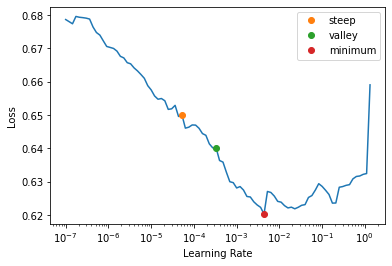

In [ ]:
get_lr = learn.lr_find(suggest_funcs=(steep, valley, minimum))  
print(f'Minimum/10: {get_lr.minimum:.2e}, steepest point: {get_lr.steep:.3e}')

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.570094,0.549146,0.672167,00:51
1,0.564588,0.550854,0.687167,00:50
2,0.559486,0.554182,0.672000,00:51
3,0.547745,0.544874,0.685000,00:51
4,0.538939,0.545634,0.673833,00:50
5,0.399615,0.712701,0.623000,00:50
6,0.151744,1.089189,0.616333,00:51


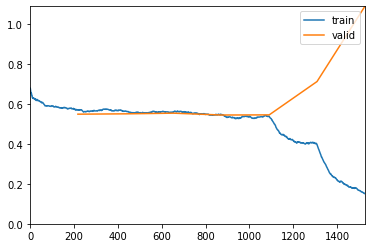

In [ ]:
learn.fit_one_cycle(7, lr_max = get_lr.valley)

In [ ]:
dls[1].vocab

AttributeError: 'Subset' object has no attribute 'vocab'

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

#### batch size 64  (DataBlock)

In [ ]:
transforms = [Resize(112), ToTensor]
dls = DataLoaders.from_dsets(
    dsets.train, dsets.valid, 
    bs=64, 
    device=device, 
    after_item=transforms, 
    after_batch=IntToFloatTensor
)

In [ ]:
dls.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learn = cnn_learner(dls, 
                    resnet34, 
                    pretrained=False,
                    path = LOG_PATH, 
                    metrics=[accuracy],                 
                    cbs=[ShowGraphCallback()])

Minimum/10: 1.74e-02, steepest point: 1.096e-04


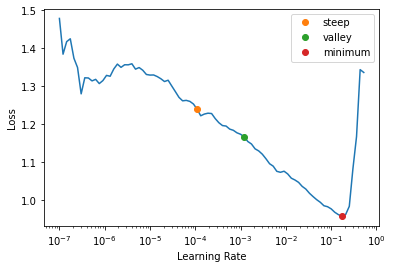

In [ ]:
get_lr = learn.lr_find(suggest_funcs=(steep, valley, minimum))  
print(f'Minimum/10: {get_lr.minimum:.2e}, steepest point: {get_lr.steep:.3e}')

epoch,train_loss,valid_loss,accuracy,time
0,0.750271,0.589833,0.607000,00:56
1,0.609312,0.570882,0.662667,00:55
2,0.588118,0.570003,0.664333,00:55
3,0.569030,0.571226,0.650333,00:55
4,0.569217,0.559694,0.671333,00:55
5,0.568339,0.556554,0.676000,00:55
6,0.550768,0.543251,0.688333,00:55
7,0.546571,0.543755,0.687667,00:55
8,0.528863,0.545744,0.685667,00:55
9,0.516344,0.546367,0.683333,00:55


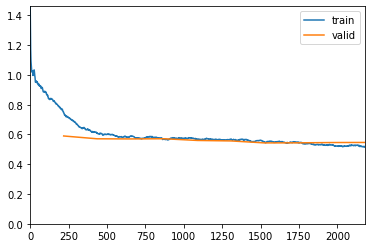

In [ ]:
learn.fit_one_cycle(10, lr_max = get_lr.valley)

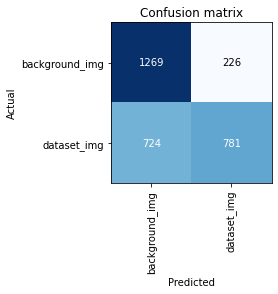

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

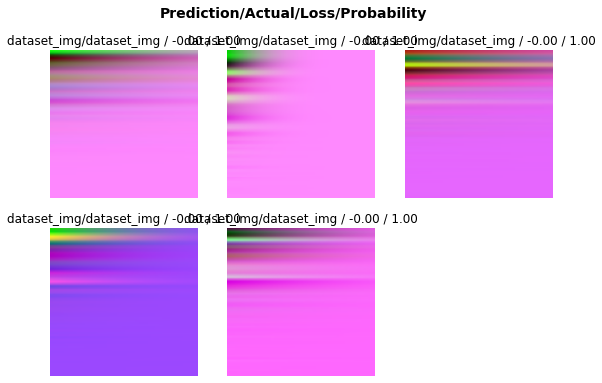

In [ ]:
interp.plot_top_losses(5, nrows=2, largest=False)

#### batch size 128

In [ ]:
dls = DataLoaders.from_dsets(ds, ds_val, bs=128, device=device)

In [ ]:
model = models.resnet34(num_classes=2)
learn = Learner(dls, model, path = LOG_PATH,
                loss_func=nn.BCEWithLogitsLoss(), 
                metrics=[accuracy_multi],                 
                cbs=[ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.590766,0.596615,0.562167,00:46
1,0.567670,0.553630,0.674333,00:44
2,0.550855,0.572860,0.643000,00:44
3,0.486514,0.675045,0.653500,00:44
4,0.316988,0.922205,0.622167,00:44
5,0.146211,1.295769,0.622500,00:44
6,0.067619,1.415175,0.624833,00:44
7,0.026308,1.509498,0.611833,00:45
8,0.014583,1.556809,0.613667,00:45
9,0.009724,1.561113,0.616167,00:44


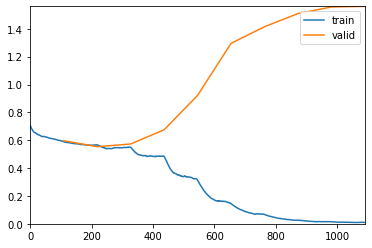

In [ ]:
learn.fit_one_cycle(10, lr_max = 1e-4)

### Loss interpretation

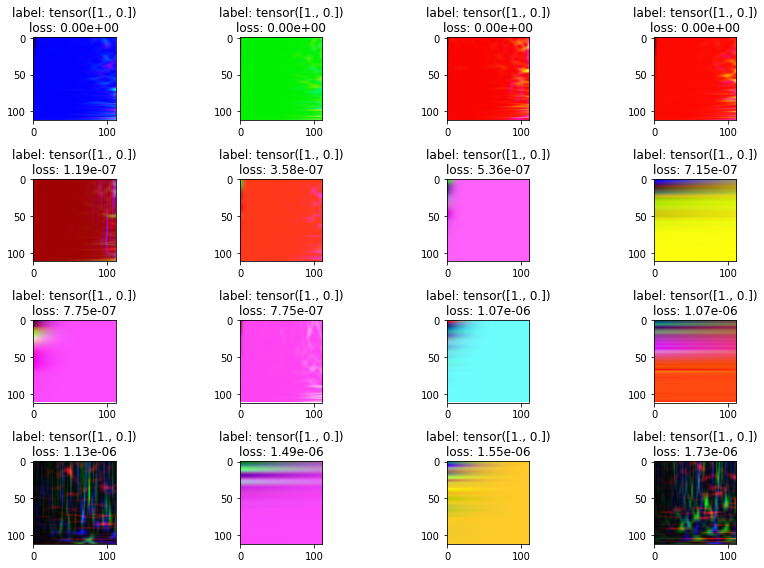

In [ ]:
interp = Interpretation.from_learner(learn)
top_losses = interp.top_losses(20, largest=False)
fig, axs = plt.subplots(4, 4, figsize=(12, 8))
for i, idx in enumerate(top_losses.indices[:16]):
    axs[i//4, i%4].imshow(ds_val[idx][0].permute(1, 2, 0))
    axs[i//4, i%4].set_title(f'label: {ds_val[idx][1]}\nloss: {top_losses.values[i]:.2e}')
fig.tight_layout()

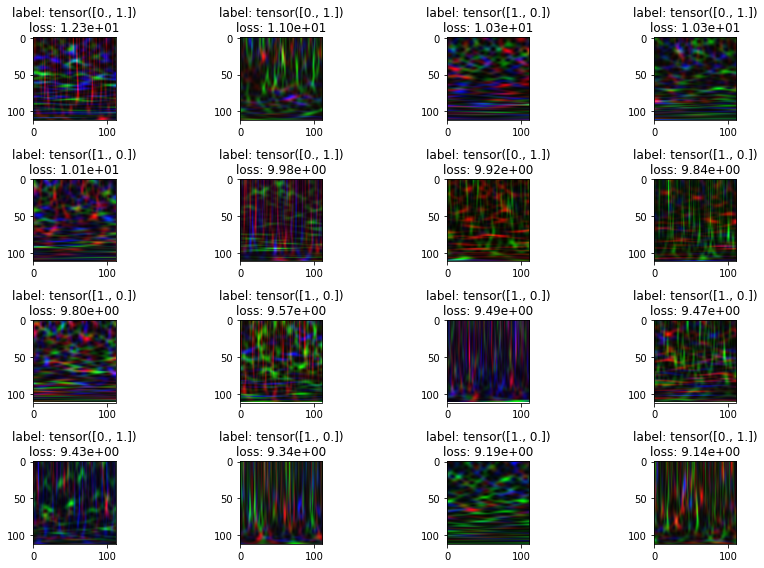

In [ ]:
interp = Interpretation.from_learner(learn)
top_losses = interp.top_losses(20, largest=True)
fig, axs = plt.subplots(4, 4, figsize=(12, 8))
for i, idx in enumerate(top_losses.indices[:16]):
    axs[i//4, i%4].imshow(ds_val[idx][0].permute(1, 2, 0))
    axs[i//4, i%4].set_title(f'label: {ds_val[idx][1]}\nloss: {top_losses.values[i]:.2e}')
fig.tight_layout()

### Plotting functions

In [ ]:
def plot_loss(recorder):
    fig, ax = plt.subplots()
    epochs = list(range(len(recorder.values)))
    ax.plot(epochs, L(recorder.values).itemgot(0), label='train')
    ax.plot(epochs, L(recorder.values).itemgot(1), label='valid')
    ax.set_title('Learning Curves')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Binary Cross Entropy')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=len(epochs), integer=True))
    ax.legend()

    return fig, ax

In [ ]:
def plot_metric(recorder):
    fig, ax = plt.subplots()
    epochs = list(range(len(recorder.values)))
    ax.plot(epochs, np.array(learn.recorder.values)[:,2])
    ax.set_ylabel('F1 score')
    ax.set_xlabel('Epoch')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=len(epochs), integer=True))

    return fig, ax

In [ ]:
def _add_to_matrix(cm):
    prec = metrics.precision_score(y_true, y_pred, average=None)
    rec = metrics.recall_score(y_true, y_pred, average=None)

    return np.vstack((cm, rec, prec))


def plot_confusion_matrix(cm, normalize=False):
    vocab = list(ds_test.class_dict.keys())
    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = _add_to_matrix(cm)
        extended_vocab = vocab + ['Recall', 'Precision']

    fig = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap='Blues', 
               aspect = 0.85 if normalize else 1)
    
    tick_marks = np.arange(len(vocab))
    plt.xticks(tick_marks, vocab, rotation=45, ha='left')
    if normalize:
        extended_tick_marks = np.arange(len(extended_vocab))
        plt.yticks(extended_tick_marks, extended_vocab)
    else:
        plt.yticks(tick_marks, vocab)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] >= 0.005:
            coeff = f'{cm[i, j]:.2f}' if normalize else f'{cm[i, j]}'
            plt.text(j, i, coeff, horizontalalignment="center", 
                     verticalalignment="center", 
                     color="white" if cm[i, j] > thresh else "black")
    ax = plt.gca()
    ax.tick_params(axis='x', length=0,
                   top=True, bottom=False, labeltop=True, labelbottom=False)
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.set_label_position("right")
    plt.tight_layout()
    plt.ylabel('Actual Class', labelpad=10)
    plt.xlabel('Predicted Class', labelpad=10)
    plt.grid(False);
    
    return fig, ax

In [ ]:
def plot_PRC(ground_truth, preds, path_to_save=None):
    
    glitch_list = list(ds_test.class_dict.keys())
    precision, recall, average_precision = {}, {}, {}

    for i in range(len(glitch_list)):
        precision[i], recall[i], _ = metrics.precision_recall_curve(ground_truth[:, i], preds[:, i])
        average_precision[i] = metrics.average_precision_score(ground_truth[:, i], preds[:, i], average='weighted')
        
    precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(ground_truth.ravel(), preds.ravel())
    average_precision["micro"] = metrics.average_precision_score(ground_truth, preds, average="micro")
     
    # setup plot details
    colors = list(mcolors.CSS4_COLORS)[::4] 
    for rm in ['navajowhite', 'white', 'azure', 'linen', 'coral', 'blanchedalmond']:
        colors.remove(rm)

    fig = plt.figure(figsize=[16,10])
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('Micro-Averaged Precision-Recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))

    for i, color in zip(range(22), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-Recall for class {0} (area = {1:0.2f})'
                      ''.format(glitch_list[i], average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title('Precision-Recall curve across all classes', fontsize=18)
    ax.legend(lines, labels,bbox_to_anchor=(1.001, 1), loc=2, prop=dict(size=14))
    
    return fig, ax

### Predictions function

In [ ]:
def get_preds(learner, ds_test):
    dl_test = learner.dls.test_dl(ds_test, with_labels=True)
    preds, targets = learner.get_preds(dl=dl_test)
    soft_preds = F.softmax(preds,dim=1)
    y_true = np.array([np.argmax(target) for target in targets])
    y_pred = [np.argmax(pred) for pred in preds]
    
    return preds, targets, soft_preds, y_true, y_pred